<a href="https://colab.research.google.com/github/saginarendravarma174/learn/blob/main/Web3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download the CSV file
!wget https://raw.githubusercontent.com/mdeshon/datacode/main/Etherscan-export.csv

--2025-05-28 13:09:49--  https://raw.githubusercontent.com/mdeshon/datacode/main/Etherscan-export.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419416 (410K) [text/plain]
Saving to: ‘Etherscan-export.csv’

Etherscan-export.cs 100%[===================>] 409.59K  --.-KB/s    in 0.02s   

2025-05-28 13:09:49 (22.6 MB/s) - ‘Etherscan-export.csv’ saved [419416/419416]



In [2]:
import pandas as pd

# Load the CSV into a Pandas DataFrame
df = pd.read_csv(
    'Etherscan-export.csv',
    dtype={
        'Value_OUT(ETH)': pd.Float32Dtype(),
        'Value_IN(ETH)': pd.Float32Dtype(),
        }
)

df['Datetime'] = pd.to_datetime(df['UnixTimestamp'], unit='s')
# Rename 'CurrentValue @...' column so the name does not contain the current Ethereum price
for column in df.columns:
  if 'CurrentValue' in column:
    df.rename(columns={column: 'CurrentValue'}, inplace=True)


# Display the first few rows of the DataFrame
print(df.head())


                                    Transaction Hash   Blockno  UnixTimestamp  \
0  0x2276b70395880e3041cb8a5c4f638a5b98d6a400c7fc...  21869539     1739836823   
1  0x52b1fbe36e1685fc24549de6169c3752db1ffad92cce...  21869545     1739836895   
2  0xf379ef1fed437d695e89a176e317f4b24d3e5253aa10...  21869545     1739836895   
3  0x799170c3c164d41155cc1510a6b2f0d6903943da5311...  21869553     1739836991   
4  0x76772fec515424cdd3abe2618219f6f0eb9591d8f2ce...  21869554     1739837003   

        DateTime (UTC)                                        From  \
0  2025-02-18 00:00:23  0x3f4e033e2686a5fd132fb0a0a48f0fcf49e26064   
1  2025-02-18 00:01:35  0xb2ba43647057dae47838ee2792c1716e55c44f0f   
2  2025-02-18 00:01:35  0x315cbdaeabd16427db821ea06dfbed11d4e9918a   
3  2025-02-18 00:03:11  0xeb1f3188ee76e76bb2b8b6cfac96b10f6f3da1e3   
4  2025-02-18 00:03:23  0xf71ed12b7667963834740d11bbcc21be3b3425db   

                                           To  ContractAddress  Value_IN(ETH)  \
0  0x3a23f9

In [3]:
# Calculate metrics
total_transactions = len(df)
total_eth_in = df['Value_IN(ETH)'].sum()

# Check if 'Value_OUT(ETH)' column exists and calculate total ETH out
if 'Value_OUT(ETH)' in df.columns:
    total_eth_out = df['Value_OUT(ETH)'].sum()
else:
    total_eth_out = "N/A" # Indicate if the column is missing

unique_sending_eoa = df['From'].nunique()
distinct_method_ids = df['Method'].nunique()

# Determine the observation window
observation_window_start = df['Datetime'].min().strftime('%Y-%m-%d %H:%M')
observation_window_end = df['Datetime'].max().strftime('%Y-%m-%d %H:%M')
observation_window = f"{observation_window_start} – {observation_window_end}"

# Create a DataFrame for the summary table
summary_data = {
    'Metric': [
        'Total transactions',
        'Total ETH bridged INTO the Socket gateway (assume this is Value_IN(ETH))',
        'Total ETH OUT (if Value_OUT(ETH) exists)',
        'Unique sending EOAs (df[\'From\'])',
        'Distinct Method IDs (df[\'Method\'])',
        'Observation window YYYY-MM-DD HH:MM – HH:MM (use the converted Datetime column)'
    ],
    'Value': [
        total_transactions,
        total_eth_in,
        total_eth_out,
        unique_sending_eoa,
        distinct_method_ids,
        observation_window
    ]
}
summary_df = pd.DataFrame(summary_data)

# Display the summary table with custom styling
display(summary_df.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]},
    {'selector': 'td', 'props': [('text-align', 'left')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]}
]))

,Metric,Value
0,Total transactions,1346
1,Total ETH bridged INTO the Socket gateway (assume this is Value_IN(ETH)),389.737854
2,Total ETH OUT (if Value_OUT(ETH) exists),0.000000
3,Unique sending EOAs (df['From']),1028
4,Distinct Method IDs (df['Method']),17
5,Observation window YYYY-MM-DD HH:MM – HH:MM (use the converted Datetime column),2025-02-18 00:00 – 2025-02-18 18:18


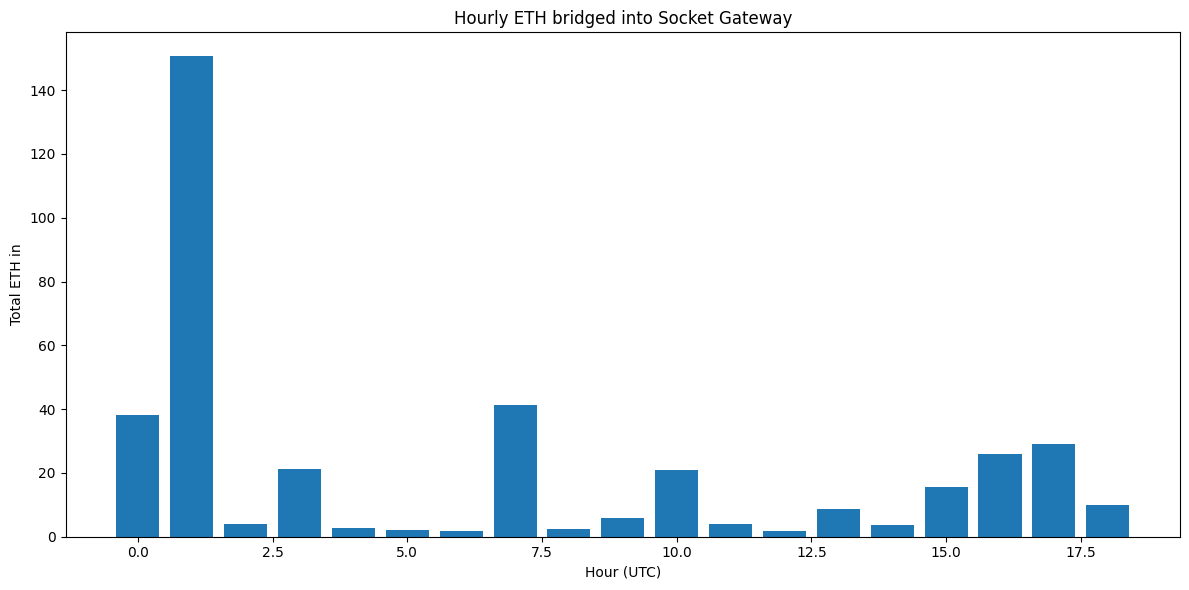

In [4]:
import matplotlib.pyplot as plt

# 1. Group by Datetime (UTC) hour and sum Value_IN(ETH)
hourly_volume = df.groupby(df['Datetime'].dt.hour)['Value_IN(ETH)'].sum()

# 2. Plot a bar chart
plt.figure(figsize=(12, 6)) # Optional: Adjust figure size for better readability
plt.bar(hourly_volume.index, hourly_volume.values)

# 3. Label x-axis and y-axis and add a title
plt.title("Hourly ETH bridged into Socket Gateway")
plt.xlabel("Hour (UTC)")
plt.ylabel("Total ETH in")

# Add plt.tight_layout()
plt.tight_layout()

# Display the plot
plt.show()

Total transactions with Value_IN(ETH) == 0: 468

Top 10 EOAs with the most zero-value transactions:


,From_EOA,zero_txns,first_seen,last_seen
283,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,67,2025-02-18 00:48:11,2025-02-18 17:58:47
190,0x9c7c10f2d2a1cc110639646f599ddb61d6751766,8,2025-02-18 06:05:47,2025-02-18 06:29:11
165,0x88b2f36284b79978a87b5480465c42151aa6459a,7,2025-02-18 10:55:23,2025-02-18 17:46:35
279,0xe9a9d424fc352a91e2a834b1b27995ee13c17343,5,2025-02-18 13:38:47,2025-02-18 16:53:11
132,0x6c70dd1293edb55e8748828174f5a12b6256921a,5,2025-02-18 08:14:23,2025-02-18 14:47:59
41,0x25177da3e18041341ea439db0b55cb63bb346dc3,4,2025-02-18 05:27:11,2025-02-18 05:40:47
23,0x14b6ba4da9ce82907005d41064c4bec58a4b8522,4,2025-02-18 08:57:23,2025-02-18 09:04:59
240,0xbfd6b54875a7aae4eb34579bba1f2a16e9521792,4,2025-02-18 15:35:35,2025-02-18 15:53:59
142,0x75d42026cbf20fc143c7250d704547c5ff1ac160,4,2025-02-18 13:49:11,2025-02-18 13:55:11
182,0x95dfbccd82e2a5eaa5f2479a336d52d6073bda0c,4,2025-02-18 05:04:35,2025-02-18 17:53:59


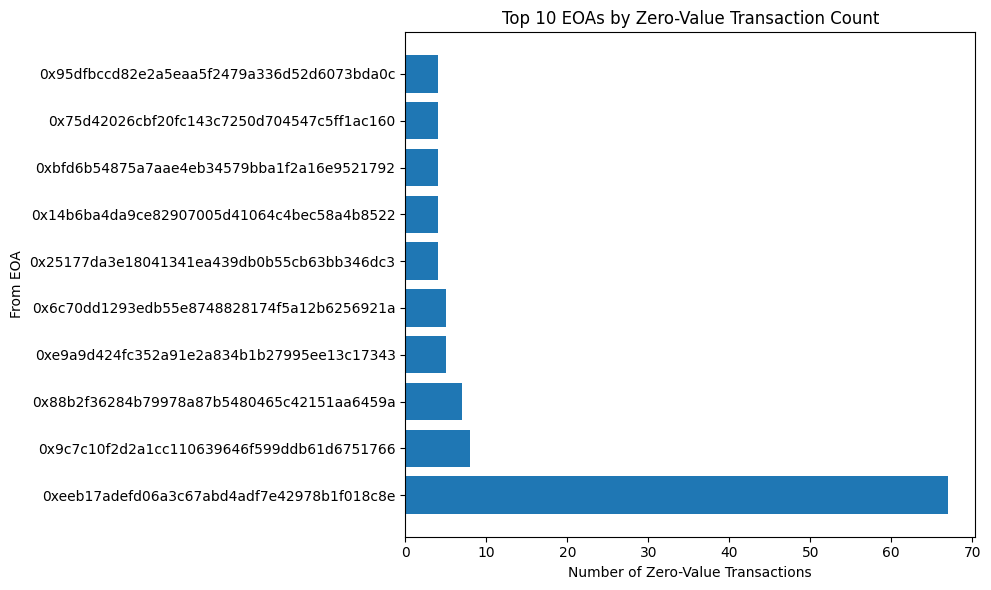


Zero-value transactions can sometimes be security-relevant as they might indicate activities like probing addresses for activity, testing network connectivity, or potentially be associated with malicious reconnaissance or denial-of-service attempts by flooding a contract with transactions that consume gas but transfer no value.


In [5]:
# Filter for zero-value transactions
zero_value_txns = df[df['Value_IN(ETH)'] == 0]

# Count total zero-value transactions
total_zero_value_txns = len(zero_value_txns)
print(f"Total transactions with Value_IN(ETH) == 0: {total_zero_value_txns}\n")

# Group by 'From' address and count zero-value transactions, find first and last seen
zero_txn_summary = zero_value_txns.groupby('From').agg(
    zero_txns=('From', 'size'),
    first_seen=('Datetime', 'min'),
    last_seen=('Datetime', 'max')
).reset_index()

# Sort by the number of zero-value transactions in descending order and get the top 10
top_10_zero_txn_senders = zero_txn_summary.sort_values(by='zero_txns', ascending=False).head(10)

# Rename the 'From' column for clarity in the output table
top_10_zero_txn_senders.rename(columns={'From': 'From_EOA'}, inplace=True)

# Print the top 10 EOAs with the most zero-value transactions
print("Top 10 EOAs with the most zero-value transactions:")
display(top_10_zero_txn_senders)

# Plot a horizontal bar chart of their counts
plt.figure(figsize=(10, 6))
plt.barh(top_10_zero_txn_senders['From_EOA'], top_10_zero_txn_senders['zero_txns'])
plt.xlabel("Number of Zero-Value Transactions")
plt.ylabel("From EOA")
plt.title("Top 10 EOAs by Zero-Value Transaction Count")
plt.tight_layout()
plt.show()

# Print explanation about security relevance
print("\nZero-value transactions can sometimes be security-relevant as they might indicate activities like probing addresses for activity, testing network connectivity, or potentially be associated with malicious reconnaissance or denial-of-service attempts by flooding a contract with transactions that consume gas but transfer no value.")

In [6]:
# Calculate value counts and percentages
method_counts = df['Method'].value_counts().reset_index()
method_counts.columns = ['method', 'count']
method_counts['pct_of_total'] = (method_counts['count'] / method_counts['count'].sum()) * 100

# Display the top 10 with styling
display(method_counts.head(10).style.highlight_max(subset=['count', 'pct_of_total'], color='lightgreen'))

,method,count,pct_of_total
0,0x000001ad,682,50.668648
1,Execute Controller,485,36.032689
2,0x000001a0,57,4.234770
3,0x00000195,33,2.451709
4,0x000001b3,29,2.154532
5,0x000001b6,12,0.891530
6,0x00000197,10,0.742942
7,0x000001b2,8,0.594354
8,0x0000019c,8,0.594354
9,0x000001ae,5,0.371471


In [ ]:
df

Top-10 bridged tokens by total ETH-equivalent value


,token,tx_count,total_value_eth
15,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,760,222.7443
14,0xdac17f958d2ee523a2206206994597c13d831ec7,20,11.9841
11,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,244,7.4020
9,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0,28,1.2350
12,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,35,0.4768
13,0xcd5fe23c85820f7b72d0926fc9b05b43e359b7ee,2,0.2000
4,0x3593d125a4f7849a1b059e64f4517a86dd60c95d,1,0.0563
8,0x6b175474e89094c44da98b954eedeac495271d0f,7,0.0392
7,0x6982508145454ce325ddbe47a25d4ec3d2311933,2,0.0039
6,0x514910771af9ca656af840dff83e8264ecf986ca,1,0.0001


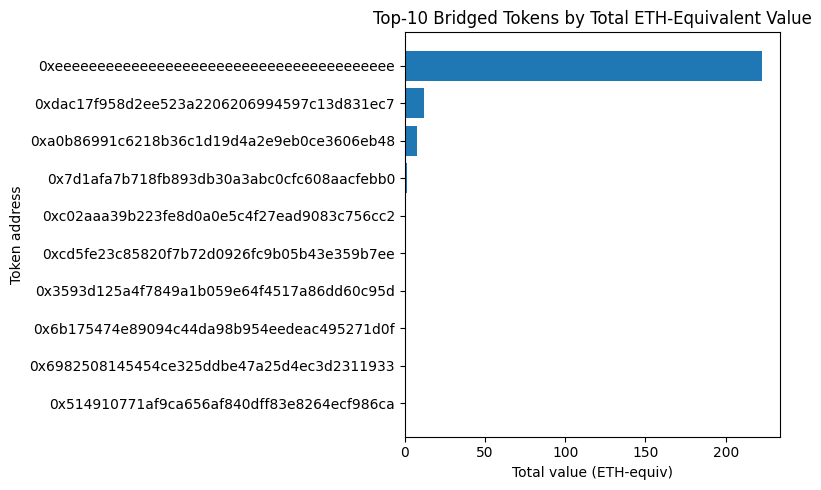

In [2]:
# Top-10 bridged tokens by total ETH-equivalent value
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load the combined Socket export
csv_path = "/content/etherscan-socket-combined.csv"
df = pd.read_csv(csv_path)

# 2) Aggregate: tx-count and total value per token
token_summary = (
    df.groupby('token', as_index=False)
      .agg(tx_count=('token', 'size'),
           total_value_eth=('value_ineth', 'sum'))
      .sort_values('total_value_eth', ascending=False)
)

# 3) Take the top-10 for display & plotting
top10 = token_summary.head(10).copy()
print("Top-10 bridged tokens by total ETH-equivalent value")
display(top10.style.format({'total_value_eth': '{:,.4f}'}))

# 4) Visualise
plt.figure(figsize=(8, 5))
plt.barh(top10['token'][::-1], top10['total_value_eth'][::-1])  # reverse for descending order
plt.title("Top-10 Bridged Tokens by Total ETH-Equivalent Value")
plt.xlabel("Total value (ETH-equiv)")
plt.ylabel("Token address")
plt.tight_layout()
plt.show()

Transactions per destination chainId


,toChainId,chain,tx_count
0,8453,Base,790
1,42161,Arbitrum,121
2,137,Polygon,106
3,56,BNB,27
4,10,Optimism,16
5,0,Other (≤ 5th place),47


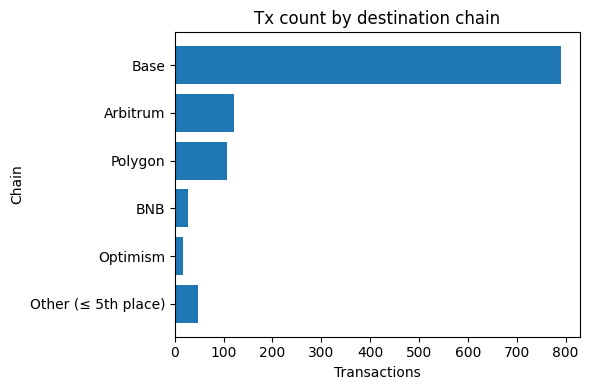

In [11]:
# Transactions by destination chain ID (Socket dataset)
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
csv_path = "/content/etherscan-socket-combined.csv"
df = pd.read_csv(csv_path)

# Basic counts by chainId
chain_counts = (
    df["toChainId"]
      .value_counts()
      .rename_axis("toChainId")
      .reset_index(name="tx_count")
)

# Optional: map common L2 IDs -> names
CHAIN_NAMES = {
    8453:  "Base",
    42161: "Arbitrum",
    137:   "Polygon",
    56:    "BNB",
    10:    "Optimism",
}
chain_counts["chain"] = chain_counts["toChainId"].map(CHAIN_NAMES).fillna("Other")

# Split top-5 vs “others”
top5        = chain_counts.head(5).copy()
others_sum  = chain_counts.iloc[5:]["tx_count"].sum()
if others_sum:
    top5.loc[len(top5)] = [0, others_sum, "Other (≤ 5th place)"]

# Display table
print("Transactions per destination chainId")
display(top5[["toChainId", "chain", "tx_count"]]
        .style.format({"tx_count":"{:,}"}))

# Bar chart
plt.figure(figsize=(6,4))
plt.barh(top5["chain"][::-1], top5["tx_count"][::-1])
plt.title("Tx count by destination chain")
plt.xlabel("Transactions")
plt.ylabel("Chain")
plt.tight_layout()
plt.show()

Loaded 1,346 rows

🔸  Transactions that ended with 'execution reverted': 205 (15.23% of all txs)

(no 'method' column in export – skipping selector analysis)

EOAs / contracts with the most reverted executions


,sender,revert_tx
0,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,11
1,0x6c70dd1293edb55e8748828174f5a12b6256921a,7
2,0x88b2f36284b79978a87b5480465c42151aa6459a,7
3,0xe9a9d424fc352a91e2a834b1b27995ee13c17343,5
4,0x04b11a7fe79c84f0891ff3d6fe93f3511c3e33ad,5
5,0x14b6ba4da9ce82907005d41064c4bec58a4b8522,4
6,0x95dfbccd82e2a5eaa5f2479a336d52d6073bda0c,4
7,0x9cebce31cd26ed0d12a8459d83f4ca8c6c783fa7,4
8,0x75d42026cbf20fc143c7250d704547c5ff1ac160,4
9,0x25177da3e18041341ea439db0b55cb63bb346dc3,4



Total gas paid on reverted txs: 0.0904 ETH
Total ETH those txs *attempted* to move: 6.0844 ETH


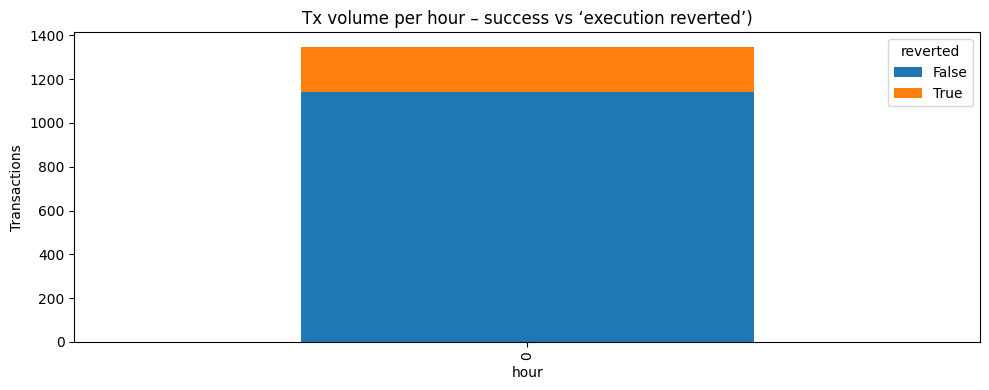

In [8]:
# ──────────────────────────────────────────────────────────────
#  Analyse "execution reverted" failures in Etherscan-export.csv
# ──────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

### 1  Load the export  (adjust path if needed)
CSV = "/content/Etherscan-export.csv"
df = pd.read_csv(CSV)
print(f"Loaded {len(df):,} rows")

### 2  Locate the ErrCode / error column
err_cols = [c for c in df.columns if "err" in c.lower() or "error" in c.lower()]
if not err_cols:
    raise ValueError("Couldn’t find a column with ErrCode / error information!")
err_col = err_cols[0]

### 3  Flag rows where ErrCode == "execution reverted"
df["reverted"] = df[err_col].astype(str).str.contains("execution reverted", case=False, na=False)
reverts = df[df["reverted"]]
num_rev  = len(reverts)
print(f"\n🔸  Transactions that ended with 'execution reverted': {num_rev:,} "
      f"({num_rev/len(df):.2%} of all txs)")

### 4  Top offenders by method selector
if "method" in df.columns:
    by_method = (reverts["method"].value_counts()
                 .head(10)
                 .rename_axis("method")
                 .reset_index(name="revert_tx"))
    print("\nTop method selectors triggering reverts")
    display(by_method)
else:
    print("\n(no 'method' column in export – skipping selector analysis)")

### 5  Addresses that generate the most reverts
sender_col = next((c for c in df.columns if c.lower().startswith("from")), None)
if sender_col:
    top_senders = (reverts[sender_col]
                   .value_counts()
                   .head(10)
                   .rename_axis("sender")
                   .reset_index(name="revert_tx"))
    print("\nEOAs / contracts with the most reverted executions")
    display(top_senders)
else:
    print("\n(no sender column found – skipping spammer analysis)")

### 6  Gas wasted on reverted txs (if gas / fee columns exist)
gas_col  = next((c for c in df.columns if "txnfee" in c.lower() and "eth" in c.lower()), None)
value_col = next((c for c in df.columns if "value_in" in c.lower() and "eth" in c.lower()), None)

if gas_col:
    gas_waste = reverts[gas_col].astype(float).sum()
    print(f"\nTotal gas paid on reverted txs: {gas_waste:,.4f} ETH")
if value_col:
    attempted = reverts[value_col].astype(float).sum()
    print(f"Total ETH those txs *attempted* to move: {attempted:,.4f} ETH")

### 7  Quick timeline – when do reverts spike?
time_col = next((c for c in df.columns if "datetime" in c.lower() or "time" in c.lower()), None)
if time_col is not None:
    df[time_col] = pd.to_datetime(df[time_col])
    df["hour"]  = df[time_col].dt.hour
    (df.groupby(["hour", "reverted"])
       .size()
       .unstack(fill_value=0)
       .plot(kind="bar", stacked=True, figsize=(10,4),
             title="Tx volume per hour – success vs ‘execution reverted’)"))
    plt.ylabel("Transactions")
    plt.tight_layout()
    plt.show()
else:
    print("\n(no timestamp column – skipping hourly chart)")

### 8  Anything suspicious?
#   — Methods with >50 % failure rate
if "method" in df.columns:
    fail_stats = (df.groupby("method")
                    .agg(total=("method","size"), rev=("reverted","sum"))
                    .assign(fail_rate=lambda d: d["rev"]/d["total"])
                    .query("total >= 5 and fail_rate > 0.5")
                    .sort_values("fail_rate", ascending=False))
    if not fail_stats.empty:
        print("\n⚠️  Selectors where >50 % of calls revert:")
        display(fail_stats.head(10))
    else:
        print("\nNo selector crosses the 50 % fail-rate threshold.")


Top senders by transaction count:


,From,tx_count,reverted_tx,total_eth,total_fee_eth
958,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,67,11,0.0000,0.0257
20,0x04b11a7fe79c84f0891ff3d6fe93f3511c3e33ad,9,5,9.1854,0.0079
604,0x9c7c10f2d2a1cc110639646f599ddb61d6751766,9,3,0.1033,0.0037
525,0x88b2f36284b79978a87b5480465c42151aa6459a,7,7,0.0000,0.0026
415,0x6c70dd1293edb55e8748828174f5a12b6256921a,7,7,0.1126,0.0027
657,0xa55a6307790023b96d9c678510d2d2d9f052d0b5,6,2,1.3265,0.0048
930,0xe9a9d424fc352a91e2a834b1b27995ee13c17343,5,5,0.0000,0.0015
140,0x25177da3e18041341ea439db0b55cb63bb346dc3,4,4,0.0000,0.0015
766,0xbfd6b54875a7aae4eb34579bba1f2a16e9521792,4,2,0.0000,0.0048
113,0x1eb017aa019b8c4b0e3dcbb1b972767dd791d47f,4,0,0.0000,0.0005


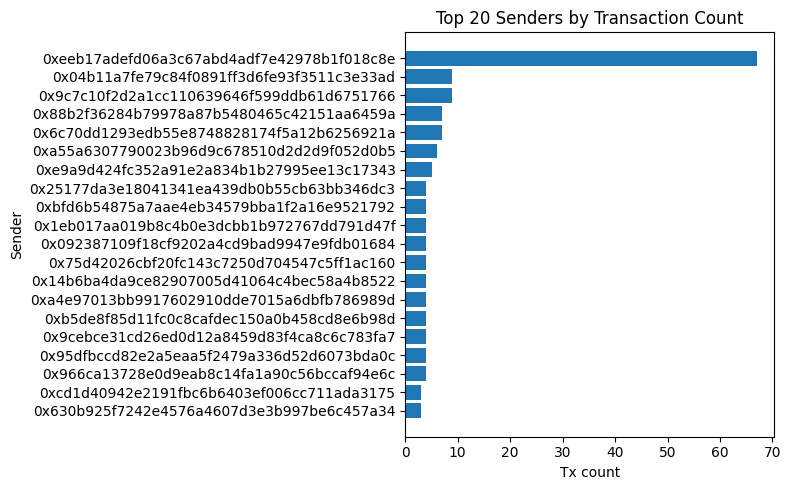

In [10]:
# ─────────────────────────────────────────────────────────────
#  Top senders overall (any outcome, not limited to reverts)
# ─────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# 1  Load the export  (tweak path if the file lives elsewhere)
CSV = "/content/Etherscan-export.csv"
df  = pd.read_csv(CSV)

# 2  Identify the sender column (e.g., tx_from / from)
sender_col = next(c for c in df.columns
                  if c.lower().startswith(("tx_from", "from")))

# 3  Optional helpers: total ETH moved, gas paid, and revert flag
value_col = next((c for c in df.columns
                  if "value_in" in c.lower() and "eth" in c.lower()), None)
fee_col   = next((c for c in df.columns
                  if "txnfee"   in c.lower() and "eth" in c.lower()), None)

# build a boolean flag if any column contains "execution reverted"
rev_col = next((c for c in df.columns
                if df[c].astype(str)
                     .str.contains("execution reverted", case=False, na=False)
                     .any()), None)
df["is_revert"] = (df[rev_col].astype(str)
                   .str.contains("execution reverted", case=False, na=False)
                   ) if rev_col else False

# 4  Aggregate per sender
agg_dict = {"tx_count": (sender_col, "size"),
            "reverted_tx": ("is_revert", "sum")}
if value_col:
    agg_dict["total_eth"] = (value_col, "sum")
if fee_col:
    agg_dict["total_fee_eth"] = (fee_col, "sum")

top_senders = (
    df.groupby(sender_col, as_index=False)
      .agg(**agg_dict)
      .sort_values("tx_count", ascending=False)
      .head(20)                        # ← change for a longer list
)

print("Top senders by transaction count:")
display(top_senders.style.format({'total_eth':      '{:,.4f}',
                                  'total_fee_eth': '{:,.4f}'}))

# 5  Visualise
plt.figure(figsize=(8,5))
plt.barh(top_senders[sender_col][::-1], top_senders["tx_count"][::-1])
plt.title("Top 20 Senders by Transaction Count")
plt.xlabel("Tx count")
plt.ylabel("Sender")
plt.tight_layout()
plt.show()


Transactions per bridge


,bridge,tx_count
0,Across Protocol,828
2,Base Bridge,50
9,Polygon Bridge,49
12,Symbiosis Finance,39
6,Hop Protocol,35
4,Circle CCTP,30
3,Celer Network,24
10,Refuel Bridge,21
8,Other / Unknown,16
5,Gnosis Native,5


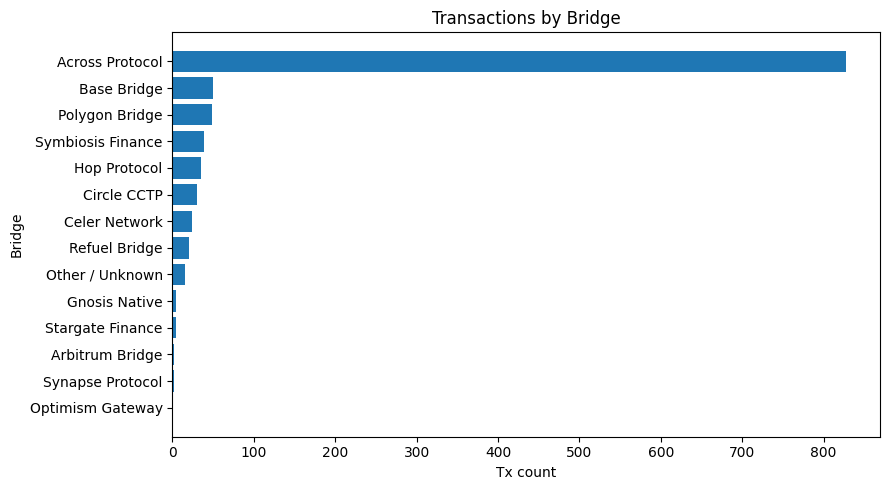

In [15]:
# ─────────────────────────────────────────────────────────
#  Transactions by Bridge (using the exact column "bridgeName")
# ─────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load the CSV  ──────────────────────────────────────────
csv_path = "/content/etherscan-socket-combined.csv"     # change if stored elsewhere
df = pd.read_csv(csv_path)

# 2) Bridge-address → friendly-name mapping  ───────────────
bridge_map = {
    "0x709f58818bedd58450336213e1f2f6ff7405a2b1e594f64270a17b7e2249419c": "Across Protocol",
    "0x837ed841e30438f54fb6b0097c30a5c4f64b47545c3df655bcd6e44bb8991e37": "Hop Protocol",
    "0x0d2fea28d1562e741fbdf63c210c9b730d85f6504e95650096acf21f93afe549": "Refuel Bridge",
    "0x6debe1c49ff1a7d2012a7d55f3935c306a5eb673882f4edde41dbcaa58467fd1": "Stargate Finance",
    "0xc77ff9af68efffed7454e77fb54f8ff0ce78a7d153d8b300824b82b55aad654f": "Celer Network",
    "0xd36025cd509d584ab5657a1932f5097aa97e23f66deca532635f79998b4f0bce": "Hyphen",
    "0xfb124487a9ad253606517a08816473db34d3f4319cda7e548f718d1bd7aec4f3": "Multichain V4",
    "0x47443678ca5bb8034d5e764a6f20d6e5cfcbb4a3912e12f8bae660cd0face530": "Synapse Protocol",
    "0x6e6ef0d56d65c2193ef8da79bb1e0bac59c8ac17fdd0b3cc6122f82f7d42cc9d": "Connext Network",
    "0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b53528072473336977bba34f4": "Polygon Bridge",
    "0xf8455f3379434a3ef6559858314c8f61d36412da9937cd3f1de59562deb078e6": "Circle CCTP",
    "0x7da5d3610317b9820c1f9de12c4c257f3f0e2ea5b63c99f27ed8e0592ac8fb4c": "Arbitrum Bridge",
    "0x2e27c951e4ed3f2f1e7771dd262432f093b6ddeabfca0688443958d00b9bcf56": "Optimism Gateway",
    "0x2e760812e6696b561a918e71ad2845639638959ed846b188488dd0d8c0b953ef": "ZkSync Era Bridge",
    "0xddc44bae4cec4168e76c8f60940ee0abbae677cacb55590a890235614317ef6b": "Zora Bridge",
    "0x86c029f16460117b4488dbcebd1ea3d4f22aee8859770297bc010a8caaa1b116": "Base Bridge",
    "0x7c4e564b66172ccd4006719b3b9e6d8e4eabbc54c5cf017495bf6a3b3f4dd06f": "Gnosis Native",
    "0xea698b477c99ea804835b684c4c3009f282df52a6bf660d4006c72a3b60fd670": "Symbiosis Finance",
    "0xcc231b7032e768dd0a97e8b21d355ca609fe31ebcb2a827b8759fc5dd1d9c95f": "Scroll Native",
    "0xc3bc0f52caacc5a87db3ce955e12a8538950098a0012cbacd0e6ff87c0606d33": "Mantle Native",
    "0x52d0275a020a4c7ae62ec6f7d7fa9498ef80508501ba5033139ff2cf4d0f631a": "Mode Native",
}

# 3) Map to friendly names  ─────────────────────────────────
df["bridge_key"] = df["bridgeName"].str.lower()           # exact column name
df["bridge"]     = df["bridge_key"].map(bridge_map).fillna("Other / Unknown")

# 4) Count transactions per bridge  ─────────────────────────
bridge_counts = (
    df.groupby("bridge")
      .size()
      .reset_index(name="tx_count")
      .sort_values("tx_count", ascending=False)
)

print("Transactions per bridge")
display(bridge_counts.style.format({"tx_count":"{:,}"}))

# 5) Bar chart  ─────────────────────────────────────────────
plt.figure(figsize=(9,5))
plt.barh(bridge_counts["bridge"][::-1], bridge_counts["tx_count"][::-1])
plt.title("Transactions by Bridge")
plt.xlabel("Tx count")
plt.ylabel("Bridge")
plt.tight_layout()
plt.show()


Top socket_sender addresses


,socket_sender,tx_count,total_eth_sent
839,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,51,0.0000
532,0x9c7c10f2d2a1cc110639646f599ddb61d6751766,6,0.1033
577,0xa55a6307790023b96d9c678510d2d2d9f052d0b5,4,1.3265
29,0x092387109f18cf9202a4cd9bad9947e9fdb01684,4,0.1384
631,0xb5de8f85d11fc0c8cafdec150a0b458cd8e6b98d,4,0.0223
18,0x04b11a7fe79c84f0891ff3d6fe93f3511c3e33ad,4,3.6208
100,0x1eb017aa019b8c4b0e3dcbb1b972767dd791d47f,4,0.0000
330,0x630b925f7242e4576a4607d3e3b997be6c457a34,3,0.0408
861,0xf423f16aae3361a114d32e3d48dc4a13910785f9,3,0.1657
558,0xa1f82642efcd7448475b4ceffb5fd653cbe20a91,3,0.0016


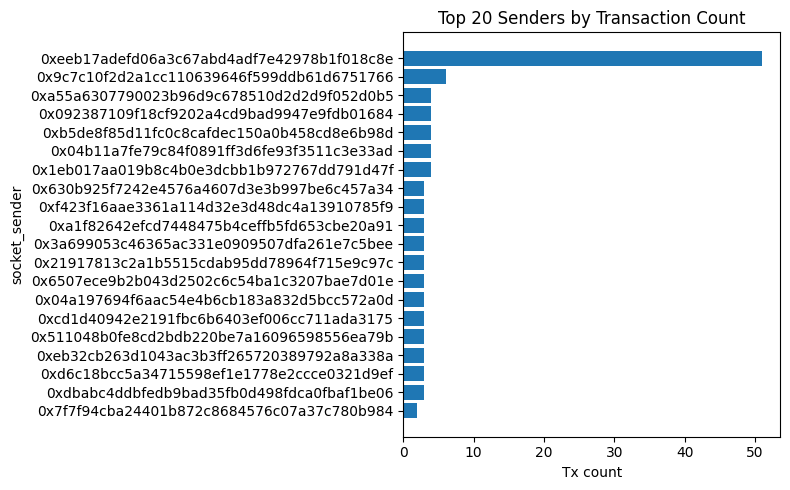

Top socket_receiver addresses


,socket_receiver,tx_count,total_eth_recv
843,0xefce5b1cd37a24b752308c93e51fb7da69e220da,51,0.0000
532,0x9c7c10f2d2a1cc110639646f599ddb61d6751766,6,0.1033
579,0xa55a6307790023b96d9c678510d2d2d9f052d0b5,4,1.3265
634,0xb5de8f85d11fc0c8cafdec150a0b458cd8e6b98d,4,0.0223
29,0x092387109f18cf9202a4cd9bad9947e9fdb01684,4,0.1384
19,0x04b11a7fe79c84f0891ff3d6fe93f3511c3e33ad,4,3.6208
101,0x1eb017aa019b8c4b0e3dcbb1b972767dd791d47f,4,0.0000
340,0x6507ece9b2b043d2502c6c54ba1c3207bae7d01e,3,0.0004
715,0xcd1d40942e2191fbc6b6403ef006cc711ada3175,3,0.0000
560,0xa1f82642efcd7448475b4ceffb5fd653cbe20a91,3,0.0016


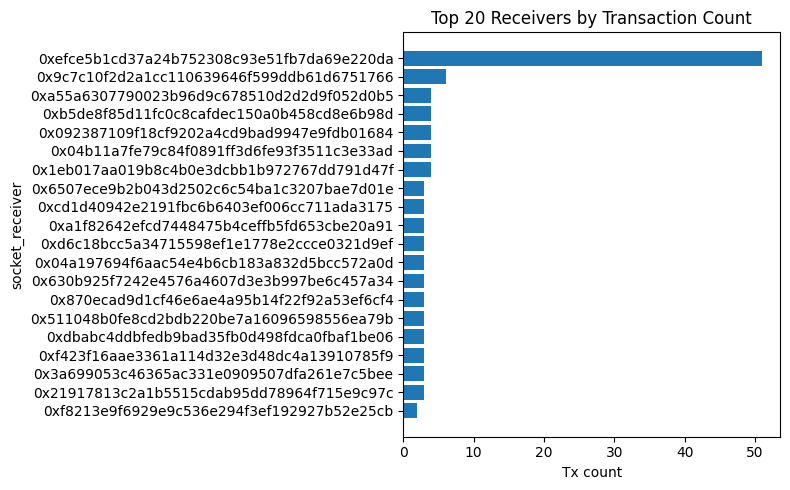

In [16]:
# ─────────────────────────────────────────────────────────────
#  Top Senders & Receivers (Socket dataset)
# ─────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load the combined export  (adjust the path if needed)
CSV = "/content/etherscan-socket-combined.csv"
df  = pd.read_csv(CSV)

# 2) Top socket_sender addresses  ────────────────────────────
senders = (
    df.groupby('socket_sender', as_index=False)
      .agg(tx_count       = ('socket_sender', 'size'),
           total_eth_sent = ('value_ineth', 'sum'))
      .sort_values('tx_count', ascending=False)
)

print("Top socket_sender addresses")
display(senders.head(20)
        .style.format({'total_eth_sent': '{:,.4f}'}))

plt.figure(figsize=(8,5))
plt.barh(senders.head(20)['socket_sender'][::-1],
         senders.head(20)['tx_count'][::-1])
plt.title("Top 20 Senders by Transaction Count")
plt.xlabel("Tx count")
plt.ylabel("socket_sender")
plt.tight_layout()
plt.show()

# 3) Top socket_receiver addresses  ──────────────────────────
receivers = (
    df.groupby('socket_receiver', as_index=False)
      .agg(tx_count        = ('socket_receiver', 'size'),
           total_eth_recv  = ('value_ineth', 'sum'))
      .sort_values('tx_count', ascending=False)
)

print("Top socket_receiver addresses")
display(receivers.head(20)
        .style.format({'total_eth_recv': '{:,.4f}'}))

plt.figure(figsize=(8,5))
plt.barh(receivers.head(20)['socket_receiver'][::-1],
         receivers.head(20)['tx_count'][::-1])
plt.title("Top 20 Receivers by Transaction Count")
plt.xlabel("Tx count")
plt.ylabel("socket_receiver")
plt.tight_layout()
plt.show()


There are exactly 51 transcations where sender and recepinet addresses differ which is but unsual

Here’s a code cell that filters the dataset for all transactions whose tx_from == 0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e , shows the rows, and gives a quick count + ETH/value summary.

In [17]:
# ─────────────────────────────────────────────────────────────
#  Filter transactions from a specific sender
# ─────────────────────────────────────────────────────────────
import pandas as pd

CSV = "/content/etherscan-socket-combined.csv"
df  = pd.read_csv(CSV)

target = "0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e"

# case-insensitive match on tx_from column
mask   = df["tx_from"].str.lower() == target.lower()
subset = df[mask].copy()

print(f"Transactions where tx_from == {target} : {len(subset):,}")
display(subset)

# Optional: basic summary
value_col = "value_ineth"
if value_col in subset.columns:
    total_val = subset[value_col].sum()
    print(f"\nTotal ETH-equiv moved by this sender: {total_val:,.4f}")
else:
    print("\n(value_ineth column not found for value summary)")


Transactions where tx_from == 0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e : 51


,tx_hash,evt_block_time,bridgeName,socket_sender,socket_receiver,tx_from,tx_to,value_ineth,txnfeeeth,txnfeeusd,method,token,toChainId
38,0x7ad810fa1ba8f439e10f498f7f8c97eedc345366fcb2...,2025-02-18 17:58:47.000 UTC,0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b5352...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.001345,3.530064,0x000001a0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137
68,0x94113db9cb6aa8836f6cef9438fd487a59a3b763e4bf...,2025-02-18 17:40:35.000 UTC,0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b5352...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.001317,3.458341,0x000001a0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137
70,0xd00c13d94e821756ea2f3f0ba4449d8e4099b4abc70b...,2025-02-18 17:38:59.000 UTC,0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b5352...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.001895,4.976582,0x000001a0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137
87,0xcb416472f1ab5568a2bcf1f76d20553f67e1b0e1c643...,2025-02-18 17:21:47.000 UTC,0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b5352...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.001151,3.022002,0x000001a0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137
128,0xec8f306ac5487d7af060018d668449b7adbb1c2b3200...,2025-02-18 16:55:35.000 UTC,0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b5352...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.000423,1.110687,0x000001a0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137
162,0x0ada89e5705610ed4e7621d2a4dbb5143c0e67e775e9...,2025-02-18 16:26:47.000 UTC,0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b5352...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.000564,1.480525,0x000001a0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137
163,0xf933d67959529f007822a8af857e7e0f30fea27069d1...,2025-02-18 16:26:11.000 UTC,0x47443678ca5bb8034d5e764a6f20d6e5cfcbb4a3912e...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.000963,2.527257,0x00000185,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137
188,0x0e464b0b6c28efde6e48701c45a66b556bb8eb519ea4...,2025-02-18 16:10:11.000 UTC,0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b5352...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.000574,1.506918,0x000001a0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137
234,0x8f13497425562f8c2b980380fe257a39caed35f85d2d...,2025-02-18 15:30:35.000 UTC,0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b5352...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.000468,1.227997,0x000001a0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137
335,0xdbc27bef714c36efc2edcf3f1fffc0b70b033ca4868a...,2025-02-18 13:53:59.000 UTC,0xf1c09a354cd800a13f6f260a3a96a0e33db28b0b5352...,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0xefce5b1cd37a24b752308c93e51fb7da69e220da,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,0x3a23f943181408eac424116af7b7790c94cb97a5,0.0,0.000264,0.692043,0x000001a0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,137



Total ETH-equiv moved by this sender: 0.0000


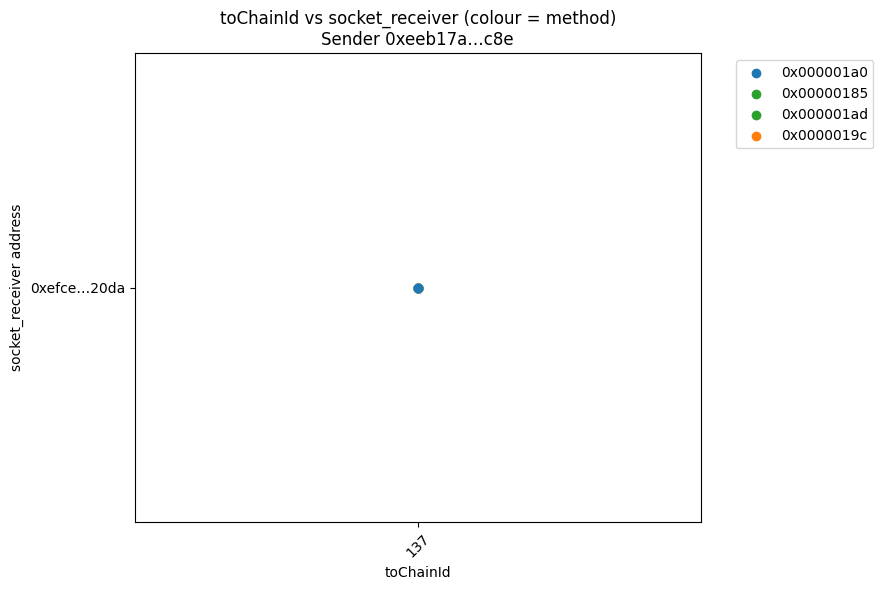

In [19]:
# ──────────────────────────────────────────────────────────────
#  Scatter: toChainId  vs  socket_receiver  (colour = method)
# ──────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

CSV = "/content/etherscan-socket-combined.csv"          # adjust if needed
df  = pd.read_csv(CSV)

target = "0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e".lower()
sub    = df[df["tx_from"].str.lower() == target]

if sub.empty:
    raise ValueError("No rows found for the target sender address!")

# --- build categorical axes ---------------------------------------------------
to_chain_ids = sorted(sub["toChainId"].unique())
chain_pos    = {cid: i for i, cid in enumerate(to_chain_ids)}

recv_addrs   = sorted(sub["socket_receiver"].unique())
recv_pos     = {addr: i for i, addr in enumerate(recv_addrs)}

# --- scatter plot -------------------------------------------------------------
plt.figure(figsize=(9, 6))
for _, row in sub.iterrows():
    x = chain_pos[row["toChainId"]]
    y = recv_pos[row["socket_receiver"]]
    plt.scatter(x, y, label=row["method"])

# deduplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks(range(len(to_chain_ids)), to_chain_ids, rotation=45)
plt.yticks(range(len(recv_addrs)),
           [addr[:6] + "…" + addr[-4:] for addr in recv_addrs])  # shorten display
plt.xlabel("toChainId")
plt.ylabel("socket_receiver address")
plt.title("toChainId vs socket_receiver (colour = method)\nSender 0xeeb17a…c8e")
plt.tight_layout()
plt.show()


Take-away

All 51 transactions sent from 0xeeb17a…c8e ultimately converged on a single Polygon receiver:

toChainId = 137 (Polygon)
Token = 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48 (USDC)

socket_receiver = 0xefce5b1cd37a24b752308c93e51fb7da69e220da

Every point uses method selector 0x000001a0, confirming a one-method, one-receiver pattern.

Interpretation

This looks like an automated bot loop rather than multichain routing or laundering